In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import pathlib
import tensorflow as tf
import os

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

Using TensorFlow backend.


# Data

In [2]:
data_dir = pathlib.Path('smalldata/train')

In [3]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)

['beach' 'bedroom' 'bridge']


In [4]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Method 1

In [5]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [6]:
for f in list_ds.take(5):
  print(f.numpy())

b'smalldata\\train\\bridge\\sun_bbtaqphbjihmcxjs.jpg'
b'smalldata\\train\\bedroom\\sun_aflpqvcumrfwsnwk.jpg'
b'smalldata\\train\\beach\\sun_bkaqtumhfwqajwkw.jpg'
b'smalldata\\train\\bridge\\sun_asusevlldapanamm.jpg'
b'smalldata\\train\\beach\\sun_apykkesglotufsbj.jpg'


In [7]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2]

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path)

In [8]:
for image, label in labeled_ds.take(10):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  b'beach'
Image shape:  (224, 224, 3)
Label:  b'bridge'
Image shape:  (224, 224, 3)
Label:  b'bedroom'
Image shape:  (224, 224, 3)
Label:  b'bedroom'
Image shape:  (224, 224, 3)
Label:  b'bedroom'
Image shape:  (224, 224, 3)
Label:  b'bedroom'
Image shape:  (224, 224, 3)
Label:  b'bridge'
Image shape:  (224, 224, 3)
Label:  b'bedroom'
Image shape:  (224, 224, 3)
Label:  b'bedroom'
Image shape:  (224, 224, 3)
Label:  b'bedroom'


# Method 2

In [9]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.333333333333333333333, rescale=1./255)

In [10]:
train_generator = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES), subset = 'training')
val_generator = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES), subset = 'validation')

Found 720 images belonging to 3 classes.
Found 360 images belonging to 3 classes.


In [11]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

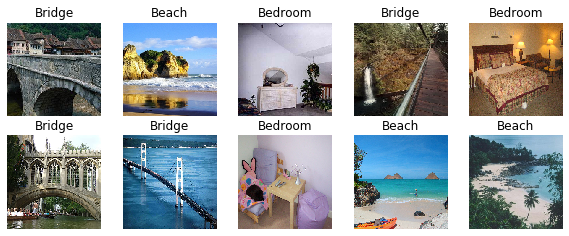

In [12]:
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

# Model

resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

#Still not talking about our train/test data or any pre-processing.

model = tf.keras.models.Sequential()

#1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
#NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(tf.keras.applications.ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))

#2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

#Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [13]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

In [14]:
base_model = tf.keras.applications.ResNet101(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [15]:
base_model.trainable = False

In [16]:
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

Total params: 42,658,176
Trainable params: 0
Non-trainable params: 42,658,176
__________________________________________________________________________________________________


In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')

In [18]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 7, 7, 2048)        42658176  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 42,664,323
Trainable params: 6,147
Non-trainable params: 42,658,176
_________________________________________________________________


In [20]:
sgd = tf.keras.optimizers.SGD(lr = 0.01, decay = 1e-6, 
                     momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = "categorical_crossentropy", metrics = ['accuracy'])

In [21]:
epochs = 3
batch_size = 32

In [22]:
history = model.fit_generator(train_generator, steps_per_epoch = len(train_generator)//batch_size,
                             epochs=epochs, validation_data = val_generator,
                             validation_steps = len(val_generator)//batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 10 steps
Epoch 1/3
10/10 [==============================] - 270s 27s/step - loss: 0.4754 - accuracy: 0.7993 - val_loss: 1.1751 - val_accuracy: 0.3313
Epoch 2/3
10/10 [==============================] - 277s 28s/step - loss: 0.0363 - accuracy: 0.9934 - val_loss: 1.9774 - val_accuracy: 0.3313
Epoch 3/3
10/10 [==============================] - 312s 31s/step - loss: 0.0801 - accuracy: 0.9750 - val_loss: 1.7629 - val_accuracy: 0.3313
